In [ ]:
import pandas as pd
import keras as keras
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
prefix=''

In [42]:
from google.colab import drive

def load_google_drive():
  drive.mount('/content/drive')
  !cd '/content/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3' && pwd
  prefix= '/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3'

load_google_drive

In [2]:
import glob
def clone_github():
  !git clone https://github.com/javierrca/eegcom.git

In [3]:
def load_file_paths(person_code):
  ds_path = "/content/eegcom/dataset"
  # person_code = "01"
  base_path = ds_path + "/" + person_code
  print('\nNamed with wildcard *:')
  paths=[]
  for name in glob.glob(base_path+'/*',recursive = True):
    paths.append(name+"/")
  print(paths)
  !cd paths[0] && ls -l
  return paths

In [5]:


def get_wavelets_ricken(X):
    brain_signal =X
    N = len(brain_signal)
    widths = np.arange(1, N//8)
    cwtmatr = signal.cwt(brain_signal, signal.ricker, widths)
    return cwtmatr

def get_wavelets_morlet2(X):
    brain_signal =X
    N = len(brain_signal)
    widths = np.arange(1, N//8)
    w = 6.
    cwtmatr =  signal.cwt(brain_signal, signal.morlet2, widths, w=w)
    return cwtmatr

def load_data_wavelets(paths):
    dfRaw = []
    X_raw_train = []
    y_raw_train =[]
    filter=[]
    filterLastRows = 1000
    i=0
    for path in paths:
        dfHead = pd.read_csv(path + 'head.csv')
        all_raw_files = glob.glob(os.path.join(path , "*RAW*.csv"))
        for filename in all_raw_files:
            dfRaw = pd.read_csv(filename, index_col=None, header=0)
            if len(dfRaw)>filterLastRows:
                qCode = dfRaw['questionCode'].iloc[[0]][0]
                X = np.array(dfRaw.tail(filterLastRows)['rawEeg'])
                samples = list()
                length = 1000
                for j in range(0,filterLastRows,length):
                    sample = X[j:j+length]
                    samples.append(sample)

                for ids, X in enumerate(samples):
                    X_raw_train.append([])
                    for idx, it in enumerate(X):
                        X_raw_train[i].append([])
                        X_raw_train[i][idx].append([])
                        X_raw_train[i][idx][0] = X[idx]
                    X_raw_train[i] = get_wavelets_ricken(np.array(X_raw_train[i]).flatten())
                    y_raw_train.append([])
                    y_raw_train[i].append([])
                    y_raw_train[i][0] = dfHead[dfHead['questionCode']==qCode].iloc[0]['response']
                    i=i+1

    return X_raw_train,y_raw_train


def get_accuraccy(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    a = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    b = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
    acc = (a + b)/2
    print ("calc accuracy : " + str(acc))
    return acc

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    plt.figure(figsize=(5,5))
    labels = ['0: No', '1: Si']
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(conf_matrix)
    print(classification_report(y_test,pred_y))
    return


X_raw_train = []
y_raw_train =[]

clone_github()
personCode="01"
paths = load_file_paths(personCode)
X_raw_train,y_raw_train= load_data_wavelets(paths)

X = np.array(X_raw_train)
y = np.array(y_raw_train)
X.shape, y.shape


Cloning into 'eegcom'...
remote: Enumerating objects: 1632, done.
remote: Counting objects: 100% (1632/1632), done.
remote: Compressing objects: 100% (1526/1526), done.
remote: Total 1632 (delta 77), reused 1629 (delta 77), pack-reused 0
Receiving objects: 100% (1632/1632), 13.91 MiB | 9.52 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Filtering content: 100% (8/8), 678.76 MiB | 41.39 MiB/s, done.

Named with wildcard *:
['/content/eegcom/dataset/01/ses11/', '/content/eegcom/dataset/01/ses15/', '/content/eegcom/dataset/01/ses16/', '/content/eegcom/dataset/01/ses23/', '/content/eegcom/dataset/01/ses02/', '/content/eegcom/dataset/01/ses14/', '/content/eegcom/dataset/01/ses05/', '/content/eegcom/dataset/01/ses13/', '/content/eegcom/dataset/01/ses21/', '/content/eegcom/dataset/01/ses04/', '/content/eegcom/dataset/01/ses01/', '/content/eegcom/dataset/01/ses18/', '/content/eegcom/dataset/01/ses08/', '/content/eegcom/dataset/01/ses12/', '/content/eegcom/dataset/01/ses22/', '/content/eegc

((225, 124, 1000), (225, 1))

In [70]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
# X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=234) # 0.25 x 0.8 = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1) # 0.25 x 0.8 = 0.2

y_val_cat =keras.utils.to_categorical(y_val,2)
y_train_cat =keras.utils.to_categorical(y_train,2)
y_test_cat =keras.utils.to_categorical(y_test,2)

X_train.shape, y_train.shape,X_test.shape,y_test.shape,X_val.shape, y_val.shape

((162, 124, 1000),
 (162, 1),
 (45, 124, 1000),
 (45, 1),
 (18, 124, 1000),
 (18, 1))

# GRAFICAS

[1]
(124, 1000)


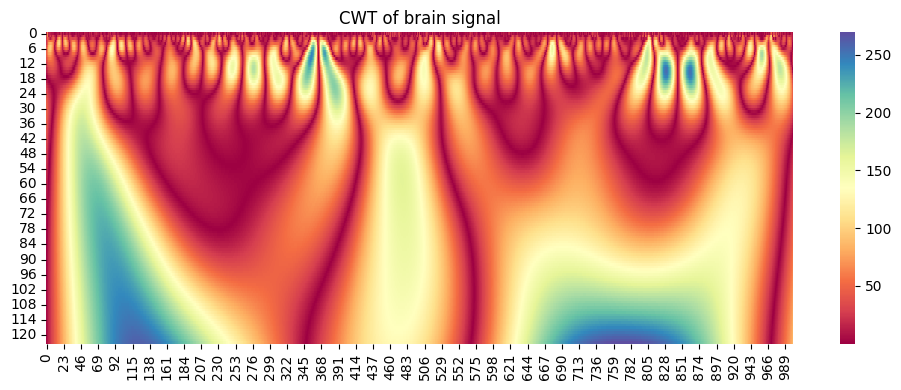

In [114]:
#ricken
N = 1000
# wvl_x = X[0].flatten()
# cwtmatr = get_wavelets(wvl_x)
i =1

print(y[i])
cwtmatr = X[i]
print(cwtmatr.shape)
# print(cwtmatr)
# print(np.abs(cwtmatr))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
# axes = ax.flatten()
axes = ax

# wvl_x =cwtmatr.flatten()
# sns.lineplot(np.linspace(0, 1000, N), wvl_x, ax=axes[0], lw=2)

# sns.heatmap(cwtmatr, cmap='Spectral', ax=axes[1]);
sns.heatmap( np.abs(cwtmatr), cmap='Spectral', ax=axes);

# axes[0].set_title('Brain signal')
axes.set_title('CWT of brain signal')

plt.tight_layout()



# MODELO

In [61]:
#model-2
from keras.utils import plot_model

from keras.layers import Conv2D, LeakyReLU

keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

input_shape=(X_train.shape[1],X_train.shape[2],1)
print(input_shape)

model = keras.Sequential()

model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation=LeakyReLU(), input_shape=(input_shape)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU()))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

model.add(Dense(128, activation=LeakyReLU()))
model.add(keras.layers.Dropout(0.2))

model.add(Dense(64, activation=LeakyReLU()))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation="sigmoid"))

opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model.summary()
# plot_model(model, 'net.png', show_shapes=True,show_layer_names=False,show_layer_activations=True)



(124, 1000, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 998, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 122, 998, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 499, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 497, 32)       4640      
                                                                 
 batch_normalization_1 (Bat  (None, 59, 497, 32)       128       
 chNormalization)                                                
                                         

# ENTRENAMIENTO

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 18.4821 - accuracy: 0.9000


Alcanzado el 85% de precisión, se cancela el entrenamiento!!
2/2 [==============================] - 0s 22ms/step
calc accuracy : 0.8392857142857142


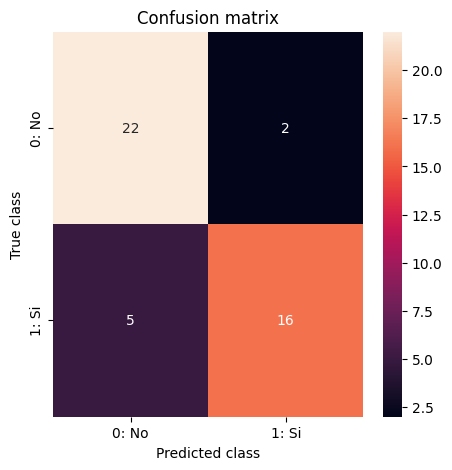

[[22  2]
 [ 5 16]]
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        24
           1       0.89      0.76      0.82        21

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45



In [73]:

class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')> 0.54 and logs.get('accuracy')> 0.65 ):
        # if( logs.get('accuracy')> 0.87 ):
              print("\nAlcanzado el 85% de precisión, se cancela el entrenamiento!!")
              self.model.stop_training = True
callbacks2 =myCallback()


# history = model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_data=(X_val, y_val_cat), shuffle=True, callbacks=[callbacks2])
# y_test_pred = model.predict(X_test)
# y_test_pred2 = [np.argmax(i) for i in y_test_pred]
# show_results(y_test,y_test_pred2)


# csv_logger = CSVLogger('training.log', separator=',', append=False)


j=0
acc=0
while j<50 and acc<0.65:
    j=j+1
    history = model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_data=(X_val, y_val_cat), shuffle=True, callbacks=[callbacks2])
    y_test_pred2 = [np.argmax(i) for i in model.predict(X_test)]
    acc = get_accuraccy(y_test,y_test_pred2)

show_results(y_test,y_test_pred2)

# EVALUACIÓN

2/2 [==============================] - 0s 42ms/step


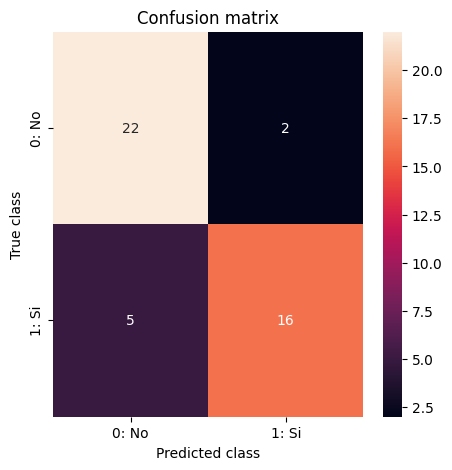

[[22  2]
 [ 5 16]]
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        24
           1       0.89      0.76      0.82        21

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45

2/2 [==============================] - 0s 28ms/step


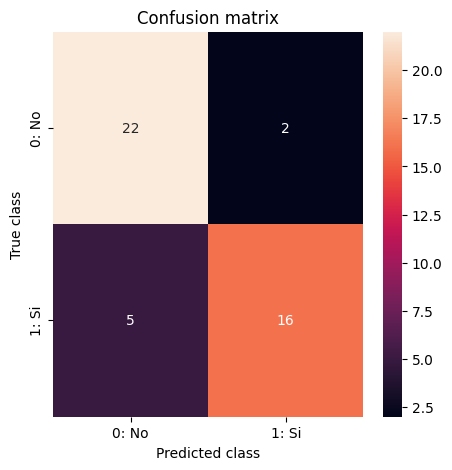

[[22  2]
 [ 5 16]]
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        24
         1.0       0.89      0.76      0.82        21

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45



In [96]:
# y_test_pred = model.predict(X)
# y_test_pred2 = [np.argmax(i) for i in y_test_pred]
# show_results(y,y_test_pred2)

# y_test_pred = model.predict(X_val)
# y_test_pred2 = [np.argmax(i) for i in y_test_pred]
# show_results(y_val,y_test_pred2)

y_test_pred = model.predict(X_test)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_test,y_test_pred2)




# SAVE MODEL AND DATA

In [78]:
# model.save('model_xxx.keras')

# y_train
def save_train_data():
  arr_reshaped = X_train.reshape(X_train.shape[0], -1)
  # Save the 2D array to a CSV file
  np.savetxt("trainfileX.csv", arr_reshaped, delimiter=",")
  np.savetxt("trainfileY.csv", y_train, delimiter=",")

# y_test
def save_test_data():
  arr_reshaped = X_test.reshape(X_test.shape[0], -1)
  # Save the 2D array to a CSV file
  np.savetxt("testfileX.csv", arr_reshaped, delimiter=",")
  np.savetxt("testfileY.csv", y_test, delimiter=",")
# y_test

def save_val_data():
  arr_reshaped = X_val.reshape(X_val.shape[0], -1)
  # Save the 2D array to a CSV file
  np.savetxt("valfileX.csv", arr_reshaped, delimiter=",")
  np.savetxt("valfileY.csv", y_val, delimiter=",")

# Load the 2D array from the CSV file
def load_x_train_data():
  loaded_arr = np.loadtxt("trainfileX.csv", delimiter=",")
  # Reshape the 2D array back to its original 3D shape
  load_original_arr = loaded_arr.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
  load_original_arr.shape
  return load_original_arr

def load_x_test_data():
  loaded_arr = np.loadtxt("testfileX.csv", delimiter=",")
  # Reshape the 2D array back to its original 3D shape
  load_original_arr = loaded_arr.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
  load_original_arr.shape
  return load_original_arr

def load_y_test_data():
  loaded_arr = np.loadtxt("testfileY.csv", delimiter=",")
  # Reshape the 2D array back to its original 3D shape
  # load_original_arr = loaded_arr
  load_original_arr = loaded_arr.reshape((y_test.shape[0], y_test.shape[1]))
  load_original_arr.shape
  return load_original_arr


# save_train_data()
# save_test_data()
# save_val_data()

x_test_loaded = load_x_test_data()
y_test_loaded = load_y_test_data()
x_test_loaded.shape, X_test.shape , y_test_loaded.shape, y_test.shape

y_test_pred = model.predict(x_test_loaded)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_test_loaded,y_test_pred2)

# LOAD STORED MODELS

2/2 [==============================] - 0s 23ms/step


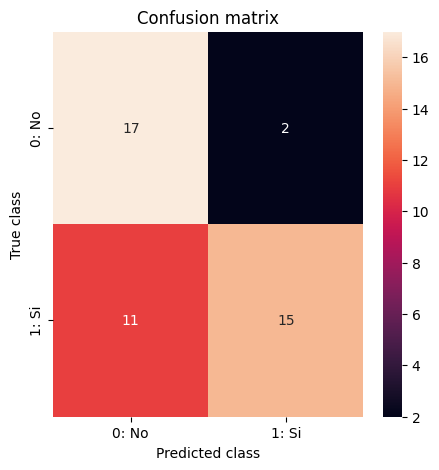

[[17  2]
 [11 15]]
              precision    recall  f1-score   support

           0       0.61      0.89      0.72        19
           1       0.88      0.58      0.70        26

    accuracy                           0.71        45
   macro avg       0.74      0.74      0.71        45
weighted avg       0.77      0.71      0.71        45



In [63]:
file = str(os.getcwd() + '/eegcom/models/CWT-CNN/' + personCode + '/' + 'CWT-CNN-U01-01.keras')
stored_model = tf.keras.models.load_model(file, compile=False)

y_test_pred = stored_model.predict(X_test)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_test,y_test_pred2)


# NEW TEST DATA

In [76]:
# ! unzip ses14.zip
test_path = "/ses14/"
paths = [ 
	 		str(os.getcwd() + test_path) ,
		]

MODEL TRAINED

MODEL trained
1/1 [==============================] - 0s 30ms/step


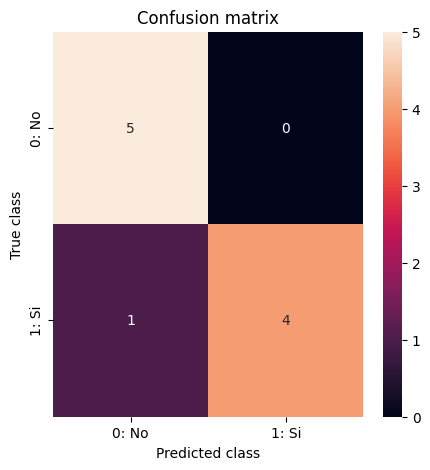

[[5 0]
 [1 4]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [77]:


X_raw_mytest,y_raw_mytest= load_data_wavelets(paths)
X_mytest = np.array(X_raw_mytest)
y_mytest = np.array(y_raw_mytest)


print ("MODEL trained")
y_test_pred = model.predict(X_mytest)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_mytest,y_test_pred2)





MODEL STORED

MODEL Stored
1/1 [==============================] - 0s 20ms/step


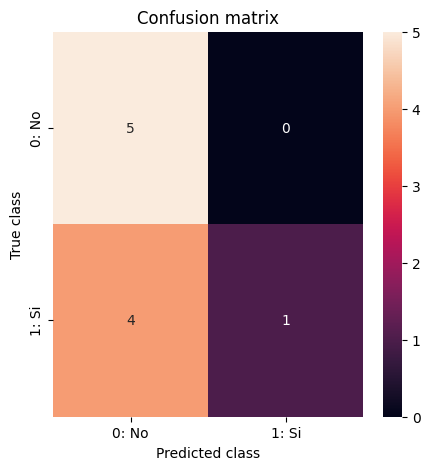

[[5 0]
 [4 1]]
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.20      0.33         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



In [65]:

print ("MODEL Stored")

y_test_pred = stored_model.predict(X_mytest)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_mytest,y_test_pred2)